In [ ]:
! pip install pymongo
! pip install matplotlib seaborn pandas

In [38]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bson, json
import os
from datetime import datetime, timedelta

### Method definition

In [4]:
# Convert bson file to dataframe
def bson_to_dataframe(filename):
    with open(f'./bson/{filename}.bson', 'rb') as f:
        data = bson.decode_all(f.read())
        df = pd.DataFrame(data)
    return df

In [5]:
# Convert json file to dataframe
def json_to_dataframe(filename):
    with open(f'./json/{filename}.json', 'rb') as f:
        data = json.load(f)
        df = pd.DataFrame(data)
    return df

In [6]:
# Calculate duration 
'''
Title: Calculate Time Difference Between Two Pandas Columns in Hours and Minutes
Author: cottontail
Date: Feb 16, 2023
Availability: https://stackoverflow.com/questions/22923775/calculate-time-difference-between-two-pandas-columns-in-hours-and-minutes
'''
def cal_total_time(start_time, end_time):
    start_time = pd.to_datetime(start_time)
    end_time = pd.to_datetime(end_time)
    duration = end_time - start_time
    duration_readable = "{:02}:{:02}:{:02}".format(int(duration.seconds / 3600), int((duration.seconds % 3600) / 60), int(duration.seconds % 60))

    return duration_readable

In [7]:
# Extract results of surveys
def extract_survey_results(dataframe):
    results = dataframe['results']

    '''
    Title: Convert Pandas Series to Dict in Python (with code)
    Author: Riddhima Agarwal
    Date: Jun 10, 2023
    Availability: https://favtutor.com/blogs/pandas-series-to-dict#:~:text=A%20Pandas%20Series%20can%20be,the%20Pandas%20Series%20as%20values
    '''
    results_list = results.to_list()
    results_df = pd.DataFrame(results_list)

    dataframe_joined = dataframe.join(results_df)
    columns = ['_id', 'results', 'createdAt', 'updatedAt', '__v']
    dataframe = dataframe_joined.drop(columns=columns, axis=1)

    return dataframe

In [8]:
# Draw heatmap to show level of familiarity, complexity and satisfaction for each user and task
def draw_heatmap(df, selected_column, cmap):
    heatmap_data = df.pivot_table(index='user_id', columns='task_id', values=selected_column, fill_value=0)

    plt.figure(figsize=(6, 3))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap=cmap, linewidths=.5)
    plt.title(f'{selected_column} heatmap')
    plt.xlabel('Task ID')
    plt.ylabel('User ID')

### Data Exploration

In [9]:
users_df = bson_to_dataframe("users")
prestudies_df = bson_to_dataframe("prestudies")
pretasks_df = bson_to_dataframe("pretasks")
sessions_df = bson_to_dataframe("sessions")
searchinteractions_df = bson_to_dataframe("searchinteractions")
documents_df = bson_to_dataframe("documents")
chatinteractions_df = bson_to_dataframe("chatinteractions")
posttasks_df = bson_to_dataframe("posttasks")
poststudies_df = bson_to_dataframe("poststudies")

tasks_df = json_to_dataframe("tasks")

In [10]:
users_df['study_total_time'] = users_df.apply(lambda row: cal_total_time(row['study_start_time'], row['study_end_time']), axis=1)
users_df = users_df[['user_id', 'study_total_time']]
users_df

,user_id,study_total_time
0,HP1,00:18:35
1,HP2,00:17:29


### Data Analysis

#### System experience

In [11]:
prestudies_df = extract_survey_results(prestudies_df)
prestudies_df

,user_id,search-engine-usage,Ai-copilots-usage,onl-search-freq,ai-search-freq
0,HP1,6,7,Multiple times per day,Multiple times per week
1,HP2,7,6,Multiple times per day,Multiple times per day


#### Pre-Task Data Analysis

##### Topical Familiarity

In [12]:
pretasks_df = extract_survey_results(pretasks_df)
pretasks_df

,user_id,task_id,familiarity,complexity
0,HP1,task1,3,2
1,HP1,task2,3,2
2,HP1,task3,3,6
3,HP1,task4,6,6
4,HP2,task1,5,2
5,HP2,task2,2,2
6,HP2,task3,3,6
7,HP2,task4,4,6


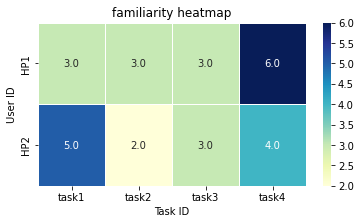

In [13]:
familiarity_heatmap = draw_heatmap(df=pretasks_df, selected_column='familiarity', cmap='YlGnBu')

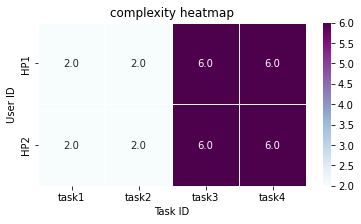

In [14]:
pre_complexity_heatmap = draw_heatmap(df=pretasks_df, selected_column='complexity', cmap='BuPu')

#### Post-Task Data Analysis

In [15]:
posttasks_df = extract_survey_results(posttasks_df)
posttasks_df

,user_id,task_id,answer,complexity-rate,satisfaction-rate,attention
0,HP1,task1,"Smoking, Being overweight, Lack of physical ac...",1,6,Okay
1,HP1,task2,Fire Ants,2,7,Okay
2,HP1,task3,aspartame: popular artificial sweetener used ...,6,6,Okay
3,HP1,task4,Disadvantages of Fossil Fuels: Land degradatio...,6,6,Okay
4,HP2,task1,"Not getting enough exercise, Drinking too much...",2,6,Okay
5,HP2,task2,"fire ants, bulldog ants",1,7,Okay
6,HP2,task3,Sodium benzoate: Prolong the shelf life of foo...,7,5,Okay
7,HP2,task4,"drawbacks of Fossil fuels: Air pollution, Wate...",7,6,Okay


##### Task complexity ratings

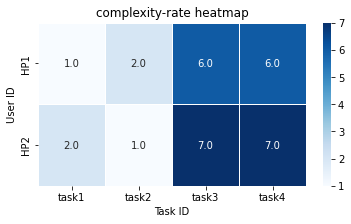

In [16]:
post_complexity_heatmap = draw_heatmap(df=posttasks_df, selected_column='complexity-rate', cmap='Blues')

##### Satisfaction ratings

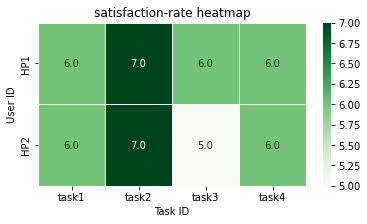

In [17]:
satisfaction_heatmap = draw_heatmap(df=posttasks_df, selected_column='satisfaction-rate', cmap='Greens')

##### Answers for evaluation

In [18]:
answers_data = posttasks_df[['user_id', 'task_id', 'answer']]
answers_data

,user_id,task_id,answer
0,HP1,task1,"Smoking, Being overweight, Lack of physical ac..."
1,HP1,task2,Fire Ants
2,HP1,task3,aspartame: popular artificial sweetener used ...
3,HP1,task4,Disadvantages of Fossil Fuels: Land degradatio...
4,HP2,task1,"Not getting enough exercise, Drinking too much..."
5,HP2,task2,"fire ants, bulldog ants"
6,HP2,task3,Sodium benzoate: Prolong the shelf life of foo...
7,HP2,task4,"drawbacks of Fossil fuels: Air pollution, Wate..."


In [19]:
# get the answer for task 3 of user HP1 
filtered_data = answers_data[(answers_data['user_id'] == 'HP1') & (answers_data['task_id'] == 'task3')]
answer = filtered_data['answer'].values[0] if not filtered_data.empty else None
answer

' aspartame: popular artificial sweetener used to improve the taste of sodas and low calorie or sugar-free foods.\n folic acid (a synthetic form of folate) are commonly added to foods because they’re more stable'

#### Demographic Data

In [20]:
poststudies_df = extract_survey_results(poststudies_df)
poststudies_df

,user_id,gender,age,qualification,occupation,enjoy,Vp-stunden,matrikel-nr
0,HP1,Female,24,High school diploma or equivalent degree,Student,"Yes, it's very interesting",True,abc12344
1,HP2,Male,23,Bachelor’s degree,Engineer,"Yes, the tasks are quite difficult but interes...",False,NaN


In [21]:
# filter only participants who need VP-Stunden
VP_data = poststudies_df[(poststudies_df['Vp-stunden'] == True)]
matrikel_nr_list = VP_data['matrikel-nr']
matrikel_nr_list

'''
Title: Writing a list to a file with Python, with newlines
Author: Alex Martelli
Date: May 22, 2009
Availability: https://stackoverflow.com/questions/899103/writing-a-list-to-a-file-with-python-with-newlines
'''
with open('matrikel_nr_list.txt', 'w') as f:
    for line in matrikel_nr_list:
        f.write(f"{line}\n")

#### Interaction Data Analysis

In [22]:
tasks_df.rename(columns={'id':'task_id'}, inplace=True)
tasks_df

,title,category,desc,task_id
0,Task 1:,simple,Your brother complains of constant headaches. ...,task1
1,Task 2:,simple,A friend has just sent an email from an Intern...,task2
2,Task 3:,complex,"You recently heard about the book ""Fast Food N...",task3
3,Task 4:,complex,Friends are planning to build a new house and ...,task4


In [23]:
sessions_df['session_total_time'] = sessions_df.apply(lambda row: cal_total_time(row['session_start_time'], row['session_end_time']), axis=1)
columns = ['_id', '__v', 'session_start_time', 'session_end_time']
sessions_df = sessions_df.drop(columns=columns, axis=1)

,session_id,user_id,task_id,session_total_time
0,acfc9aab-4689-42be-b36e-8a8e42d797fb,HP1,task1,00:02:23
1,64ad6db3-e360-4d63-82e1-a8722b8e99d2,HP1,task2,00:02:04
2,bd189b9f-18da-448f-8cca-02ee19bf8761,HP1,task3,00:01:03
3,db1d406b-6953-4d92-ba49-8244f586a1f9,HP1,task4,00:04:42
4,f2e28367-0f4f-42be-8d6f-71afa9f77f28,HP2,task1,00:02:10
5,cb9dcc10-ec41-4f4a-8238-eb1356dfed18,HP2,task2,00:02:13
6,1650f09d-8ef5-4745-8e0c-f460b4fd432c,HP2,task3,00:01:41
7,dfc539c7-cf3d-4bee-92df-7a6e92e42074,HP2,task4,00:03:10


In [28]:
sessions_df

,session_id,user_id,task_id,session_total_time
0,acfc9aab-4689-42be-b36e-8a8e42d797fb,HP1,task1,00:02:23
1,64ad6db3-e360-4d63-82e1-a8722b8e99d2,HP1,task2,00:02:04
2,bd189b9f-18da-448f-8cca-02ee19bf8761,HP1,task3,00:01:03
3,db1d406b-6953-4d92-ba49-8244f586a1f9,HP1,task4,00:04:42
4,f2e28367-0f4f-42be-8d6f-71afa9f77f28,HP2,task1,00:02:10
5,cb9dcc10-ec41-4f4a-8238-eb1356dfed18,HP2,task2,00:02:13
6,1650f09d-8ef5-4745-8e0c-f460b4fd432c,HP2,task3,00:01:41
7,dfc539c7-cf3d-4bee-92df-7a6e92e42074,HP2,task4,00:03:10


##### Time overall

In [174]:
sessions_merged_df= pd.merge(sessions_df, tasks_df, on='task_id', how='left')
sessions_merged_df = sessions_merged_df.drop(['title'], axis=1)

In [175]:
sessions_merged_df 

,session_id,user_id,task_id,session_total_time,category,desc
0,acfc9aab-4689-42be-b36e-8a8e42d797fb,HP1,task1,00:02:23,simple,Your brother complains of constant headaches. ...
1,64ad6db3-e360-4d63-82e1-a8722b8e99d2,HP1,task2,00:02:04,simple,A friend has just sent an email from an Intern...
2,bd189b9f-18da-448f-8cca-02ee19bf8761,HP1,task3,00:01:03,complex,"You recently heard about the book ""Fast Food N..."
3,db1d406b-6953-4d92-ba49-8244f586a1f9,HP1,task4,00:04:42,complex,Friends are planning to build a new house and ...
4,f2e28367-0f4f-42be-8d6f-71afa9f77f28,HP2,task1,00:02:10,simple,Your brother complains of constant headaches. ...
5,cb9dcc10-ec41-4f4a-8238-eb1356dfed18,HP2,task2,00:02:13,simple,A friend has just sent an email from an Intern...
6,1650f09d-8ef5-4745-8e0c-f460b4fd432c,HP2,task3,00:01:41,complex,"You recently heard about the book ""Fast Food N..."
7,dfc539c7-cf3d-4bee-92df-7a6e92e42074,HP2,task4,00:03:10,complex,Friends are planning to build a new house and ...


In [176]:
task_time_df = sessions_merged_df[['task_id', 'session_total_time']]
task_time_df

,task_id,session_total_time
0,task1,00:02:23
1,task2,00:02:04
2,task3,00:01:03
3,task4,00:04:42
4,task1,00:02:10
5,task2,00:02:13
6,task3,00:01:41
7,task4,00:03:10


In [177]:
# calculate the overall time for each task
def cal_time_each_task(dataframe):
    task_time_list = dataframe.to_dict('records')

    task_time_dict = {}

    for entry in task_time_list:
        task_id = entry["task_id"]
        session_time = datetime.strptime(entry["session_total_time"], "%H:%M:%S")
        if task_id in task_time_dict:
            task_time_dict[task_id] += session_time - datetime(1900, 1, 1)
        else:
            task_time_dict[task_id] = session_time - datetime(1900, 1, 1)

    return task_time_dict

In [178]:
# Visualization using bar chart
'''
Title: Bar Plot in Matplotlib
Author: jeeteshgavand
Date: 04 Mar, 2021
Availability: https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
'''
def visualize_time_each_task(task_time_dict):
    # Figure Size
    fig, ax = plt.subplots(figsize =(8, 3))
    
    task_overalltime_minutes = {key: value.total_seconds()/60 for key, value in task_time_dict.items()}

    tasks = list(task_overalltime_minutes.keys())
    minutes = list(task_overalltime_minutes.values())
    # Horizontal Bar Plot
    ax.barh(tasks, minutes)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    
    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    
    # Show top values 
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5, 
                str(round((i.get_width()), 2)),
                fontsize = 10, fontweight ='bold',
                color ='grey')
    
        # Adding labels and title
    ax.set_xlabel('Minutes')
    ax.set_title('Overall Time for each Task',
                loc ='left', )

In [179]:
def visualize_overalltime(task_time_dict): 
    simple_tasks_overalltime = (task_time_dict['task1'] + task_time_dict['task2']).total_seconds()/60
    complex_tasks_overalltime =(task_time_dict['task3'] + task_time_dict['task4']).total_seconds()/60

    # Data for plotting
    tasks = ['Simple Tasks', 'Complex Tasks']
    times = [simple_tasks_overalltime, complex_tasks_overalltime]

    fig = plt.figure(figsize = (5, 3))

    # Plotting the bar chart
    plt.bar(tasks, times, color ='maroon')

    # Adding labels and title
    plt.xlabel('Task Type')
    plt.ylabel('Overall Time (minutes)')
    plt.title('Overall Time for Simple vs Complex Tasks')

In [180]:
# calculate the overall time for each type of tasks
def print_overalltime(task_time_dict):
    
    # Convert total times to string format
    simple_tasks_overalltime = str(task_time_dict['task1'] + task_time_dict['task2'])
    complex_tasks_overalltime = str(task_time_dict['task3'] + task_time_dict['task4'])

    for task_id, total_time in task_time_dict.items():
        task_time_dict[task_id] = str(total_time)

    # print overalltime
    print("Overall time for each task:")
    for task_id, total_time in task_time_dict.items():
        print(f"{task_id}: {total_time}")

    print('Overall time for simple tasks: ' + simple_tasks_overalltime)
    print('Overall time for complex tasks: ' + complex_tasks_overalltime)

Overall time for each task:
task1: 0:04:33
task2: 0:04:17
task3: 0:02:44
task4: 0:07:52
Overall time for simple tasks: 0:08:50
Overall time for complex tasks: 0:10:36


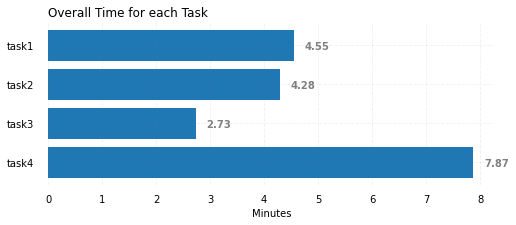

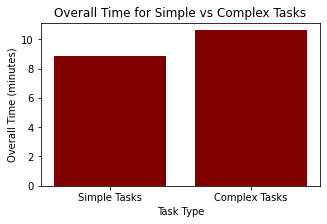

In [181]:
task_overalltime = cal_time_each_task(task_time_df)
visualize_time_each_task(task_overalltime)
visualize_overalltime(task_overalltime)
print_overalltime(task_overalltime)

In [182]:
searchinteractions_df

,_id,interaction_id,user_id,session_id,interaction_type,query,number_of_retrieved_docs,createdAt,updatedAt,__v
0,65ed93b2b6ec4550d1931559,dbc365d9-2f4c-4183-a4df-58fd7981982c,HP1,acfc9aab-4689-42be-b36e-8a8e42d797fb,google,reasons of high blood pressure,"1,590,000,000",2024-03-10 11:04:18.022,2024-03-10 11:04:18.022,0
1,65ed94a9b6ec4550d193156d,8b43324f-3d3b-44da-9de2-bca1334f7470,HP1,64ad6db3-e360-4d63-82e1-a8722b8e99d2,google,one specie of dangerous ant,"20,200,000",2024-03-10 11:08:25.910,2024-03-10 11:08:25.910,0
2,65ed960ab6ec4550d1931583,f4f26014-6ffb-4e45-8fe9-009395fd277f,HP1,db1d406b-6953-4d92-ba49-8244f586a1f9,google,issues of conventional methods of home heating,"104,000,000",2024-03-10 11:14:18.455,2024-03-10 11:14:18.455,0
3,65ed9642b6ec4550d193158b,f4f26014-6ffb-4e45-8fe9-009395fd277f,HP1,db1d406b-6953-4d92-ba49-8244f586a1f9,google,issues of solar panels,"249,000,000",2024-03-10 11:15:14.300,2024-03-10 11:15:14.300,0
4,65ed96e1b6ec4550d1931591,f4f26014-6ffb-4e45-8fe9-009395fd277f,HP1,db1d406b-6953-4d92-ba49-8244f586a1f9,google,issues of conventional methods of home heating...,"52,400,000",2024-03-10 11:17:53.370,2024-03-10 11:17:53.370,0
5,65ed99c0db0fdc3e4460d74a,c82d84e9-e420-4bda-8a83-ec00e8c72025,HP2,f2e28367-0f4f-42be-8d6f-71afa9f77f28,google,what causes high blood pressure?,"1,190,000,000",2024-03-10 11:30:08.074,2024-03-10 11:30:08.074,0
6,65ed9a8adb0fdc3e4460d758,88d63e3d-8237-4e51-9da3-3dbc1c210798,HP2,cb9dcc10-ec41-4f4a-8238-eb1356dfed18,google,one specie of dangerous ant,"20,200,000",2024-03-10 11:33:30.246,2024-03-10 11:33:30.246,0
7,65ed9c02db0fdc3e4460d770,e2e51c24-0b7a-4a3e-b38a-e9a2ff994c37,HP2,dfc539c7-cf3d-4bee-92df-7a6e92e42074,google,issues fossil energy sources,"130,000,000",2024-03-10 11:39:46.793,2024-03-10 11:39:46.793,0
8,65ed9c6adb0fdc3e4460d77a,e2e51c24-0b7a-4a3e-b38a-e9a2ff994c37,HP2,dfc539c7-cf3d-4bee-92df-7a6e92e42074,google,issues fossil energy sources home heating,"43,400,000",2024-03-10 11:41:30.774,2024-03-10 11:41:30.774,0
9,65ed9c8ddb0fdc3e4460d77e,e2e51c24-0b7a-4a3e-b38a-e9a2ff994c37,HP2,dfc539c7-cf3d-4bee-92df-7a6e92e42074,google,issues solar panels home heating,"168,000,000",2024-03-10 11:42:05.659,2024-03-10 11:42:05.659,0
